In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord, proj_plane_pixel_scales
from skimage.draw import ellipse
from photutils.segmentation import detect_sources


plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True

In [25]:
field = 'CEERS'
with fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*ir*sci*.fits")[0], memmap=True) as hdul:
    wcs = WCS(hdul[0].header)
    mask = np.zeros(hdul[0].data.shape)
with fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)

In [26]:
# Calculate mean fluxes and mag for initial values in model fitting
filter_list = ['f115w','f150w','f277w','f444w']

flux_mean = np.nanmean([phot_dja[f'{filter}_tot_1'] for filter in filter_list], axis=0)
mag_mean  = np.nanmean([(phot_dja[f'{filter}_tot_1']*10*u.nJy).to(u.ABmag).value for filter in filter_list], axis=0)

flux_mean = np.nan_to_num(flux_mean, nan=np.nanmean(phot_dja['f277w_tot_1']))
mag_mean = np.nan_to_num(mag_mean, nan=25)

/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/tmp/ipykernel_26888/1260666297.py:5: RuntimeWarning: Mean of empty slice
  mag_mean  = np.nanmean([(phot_dja[f'{filter}_tot_1']*10*u.nJy).to(u.ABmag).value for filter in filter_list], axis=0)


In [27]:
# Create association catalog
data = Table()
data['ra'] = phot_dja['ra']                                    # 1
data['dec'] = phot_dja['dec']                                  # 2
data['group_id'] = np.arange(len(phot_dja))                    # 3
data['flux_mean']  = flux_mean                                 # 4
data['a_image'] = phot_dja['a_image']                          # 5
data['b_image'] = phot_dja['b_image']                          # 6
data['theta_image'] = phot_dja['theta_image']                  # 7
data['axratio'] = phot_dja['a_image']/phot_dja['b_image']      # 8
data['bigsize'] = phot_dja['a_image']*5                        # 9
data['mag_mean'] = mag_mean                                    # 10
px_scale = proj_plane_pixel_scales(wcs)[0]*3600
data['bigsize'][data['bigsize'] < 5] = 5
data['bigsize'][data['a_image'] > 0.9/px_scale] = 2/3 * 0.9/px_scale

In [28]:
# Create segmentation map
coord = SkyCoord(data['ra'], data['dec'], unit='deg')
coord_px = skycoord_to_pixel(coord, wcs)
coord_px_ra, coord_px_de = coord_px

for i in range(len(data)):
    # if (i % 10000) == 0:
    #     print(i)
    rr, cc = ellipse(coord_px_de[i], coord_px_ra[i], 
                     r_radius=np.clip(data['b_image'][i]*8, 0.6/px_scale, 10/px_scale), 
                     c_radius=np.clip(data['a_image'][i]*6, 0.6/px_scale, 10/px_scale), 
                     rotation=np.deg2rad(-data['theta_image'][i]))
    inside = np.where((rr>=0)&(rr<mask.shape[0])&(cc>=0)&(cc<mask.shape[1]))[0]
    rr = rr[inside]
    cc = cc[inside]
    mask[rr, cc] = 1
segment_map = detect_sources(mask, threshold=0.1, npixels=1)

for x,y,obj in zip(coord_px_ra, coord_px_de, data):
    x = int(x)
    y = int(y)
    if (x>=0) & (y>=0) & (x<mask.shape[0]) & (y<mask.shape[1]):
        if mask[y, x] == 1:
            obj['group_id'] = int(segment_map.data[y, x])
    else:
        obj['group_id'] = -1

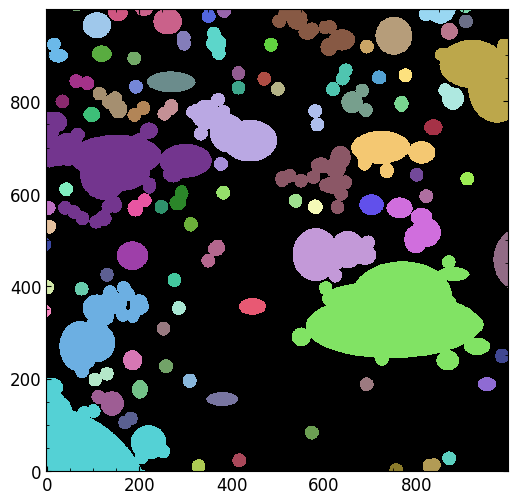

In [29]:
# Show segmentation map cutout
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(segment_map[mask.shape[0]//2-500:mask.shape[0]//2+500,mask.shape[1]//2-500:mask.shape[1]//2+500], 
          origin='lower', cmap=segment_map.cmap, interpolation='nearest')
plt.show()

In [30]:
# Save association catalog
fname = ".".join(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*ir*sci*.fits")[0].split("/")[-1].split(".")[:-1])
ascii.write(data, f"/home/aurelien/DAWN/DJA_SE++/catalog/{field}/{fname}_assoc-cat.txt", 
            overwrite=True, delimiter='\t', comment='#', names=data.keys())